In [1]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_probability import distributions as tfd
from sklearn.metrics import mean_absolute_error, mean_squared_error

from utils import *

## Display Results

In [2]:
results = pd.read_csv('results.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: Non-probabilistic MLP
Train RMSE                                         27.43
Train MAE                                          16.39
Test RMSE                                          27.97
Test MAE                                           16.68
Test % within 99.00% CI                            96.22726192676294


Model: Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Train RMSE                                         124.99
Train MAE                                          92.54
Test RMSE                                          124.93
Test MAE                                           92.37
Test % within 99.00% CI                            17.168730364073184


Model: Epistemic Uncertainty BNN (Flipout)
Train RMSE                                         29.38
Train MAE                                          18.14
Test RMSE                                          29.74
Test MAE                                           18.25
Test % within 99.00% CI                   

In [3]:
"""
Format results to be added to a latex table.
"""

results = pd.read_csv('results.csv')

# Get the list of metrics
metrics = results.columns[1:]

# Print results
for idx, row in results.iterrows():
    # print(row['Model Name'])
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass  # If conversion fails, keep the original value
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = row['Model Name'] + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")

Non-probabilistic MLP 27.43 & 16.39 & 27.97 & 16.68 & 96.23\% \\


Epistemic Uncertainty BNN (Flipout) - 1.0% Sample 124.99 & 92.54 & 124.93 & 92.37 & 17.17\% \\


Epistemic Uncertainty BNN (Flipout) 29.38 & 18.14 & 29.74 & 18.25 & 25.59\% \\


Stochastic Output BNN (Flipout) 569.53 & 368.60 & 569.11 & 367.50 & 7.82\% \\


Probabilistic MLP (Separate Sub-models) 49.15 & 30.16 & 49.05 & 30.07 & 93.31\% \\


Probabilistic MLP (Joint Sub-models) 67.34 & 41.09 & 66.86 & 40.81 & 98.02\% \\


Probabilistic CNN with Gaussian Output 271.13 & 192.23 & 270.53 & 192.03 & 99.92\% \\


Non-Bayesian Multivariate (Only Diagonal) 237.36 & 173.29 & 237.74 & 174.52 & 88.11\% \\


Probabilistic Multivariate MLP (Only Diagonal) 426.07 & 295.08 & 430.43 & 299.52 & 11.94\% \\


Probabilistic Multivariate MLP (Lower Triangular Covariance Matrix) 943.51 & 687.71 & 955.25 & 699.34 & 2.50\% \\


GP (RBF, only-wind) 65.46 & 46.60 & 68.85 & 46.52 & -\% \\


RBF 26.22 & 18.21 & 45.47 & 29.61 & -\% \\


Matern 13.4

## Additional Plots

In [4]:
DATA_PATH = "."

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned_data_train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned_data_test.pkl','rb'))

In [5]:
# Datetime column
DATETIME_COL = 'Date.time'

units = {
'Wind.speed.me': 'm/s',
'Wind.speed.sd': 'm/s', 
'Wind.speed.min': 'm/s',
'Wind.speed.max': 'm/s',
'Front.bearing.temp.me': '°C',
'Front.bearing.temp.sd': '°C',
'Front.bearing.temp.min': '°C',
'Front.bearing.temp.max': '°C',
'Rear.bearing.temp.me': '°C',
'Rear.bearing.temp.sd': '°C',
'Rear.bearing.temp.min': '°C',
'Rear.bearing.temp.max': '°C',
'Rotor.bearing.temp.me': '°C',
'Stator1.temp.me': '°C',
'Nacelle.ambient.temp.me': '°C',
'Nacelle.temp.me': '°C',
'Transformer.temp.me': '°C',
'Gear.oil.temp.me': '°C',
'Gear.oil.inlet.temp.me': '°C',
'Top.box.temp.me': '°C',
'Hub.temp.me': '°C',
'Conv.Amb.temp.me': '°C',
'Rotor.bearing.temp.me': '°C',
'Transformer.cell.temp.me': '°C',
'Motor.axis1.temp.me': '°C',
'Motor.axis2.temp.me': '°C',
'CPU.temp.me': '°C',
'Blade.ang.pitch.pos.A.me': '°',
'Blade.ang.pitch.pos.B.me': '°',
'Blade.ang.pitch.pos.C.me': '°',
'Gear.oil.inlet.press.me': 'bar',
'Gear.oil.pump.press.me': 'bar',
'Drive.train.acceleration.me': 'mm/s^2',
'Tower.Acceleration.x': 'mm/s^2',
'Tower.Acceleration.y': 'mm/s^2'
}

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.inlet.temp.me',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'
TURBINE_ID = 5

print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

TURBINE_ID = 5
df_train_single = df_train[df_train['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#{TURBINE_ID} Training Set Size:  807764
Turbine#{TURBINE_ID} Testing Set Size:  201943


In [6]:
X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, features, output_feature)

In [7]:
def plot_confidence_interval_bar_grid(y_test_pred_list, y_test_std_list, y_test_list, bins=20, rmses=None, titles=None, save_path=None):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (y_test_pred, y_test_std, y_test) in enumerate(zip(y_test_pred_list, y_test_std_list, y_test_list)):
        percentages_within_interval = []
        for t_value in t_values:
            lower_bounds = y_test_pred.ravel() - t_value * y_test_std
            upper_bounds = y_test_pred.ravel() + t_value * y_test_std

            # Count number of data points within the confidence interval
            is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
            num_within_interval = np.sum(is_within_interval)

            # Calculate the percentage of data points within the confidence interval
            percentage_within_interval = (num_within_interval / len(y_test)) * 100
            percentages_within_interval.append(percentage_within_interval)

        row = i // 2
        col = i % 2

        bars = axes[row, col].bar(np.arange(1, bins+1)*100/bins, percentages_within_interval, color='#76b5c5', width=80/bins, edgecolor='black', alpha=0.9, label='Percentage of Residuals within Interval')
        axes[row, col].plot([0, 100], [0, 100], color='red', linestyle='--', label='Expected')
        
        # Calculate differences between the blue bars and the expected line
        expectations = np.arange(1, bins+1)*100/bins
        differences = np.array(percentages_within_interval) - expectations

        # Plot individual red bars for each discrepancy
        for j, difference in enumerate(differences):
            if difference != 0:
                axes[row, col].bar((j+1)*100/bins, abs(difference), bottom=min(percentages_within_interval[j], expectations[j]), color='red', width=80/bins, edgecolor='black', alpha=0.3)
                
        axes[row, col].text(0, 100, f'MCE: {max(abs(differences)):.2f}', ha='left', va='top') 
        if rmses is not None and len(rmses) > i:
            axes[row, col].text(0, 90, f'RMSE: {rmses[i]:.2f}', ha='left', va='top') 

        axes[row, col].set_xlabel('Confidence Intervals')
        axes[row, col].set_ylabel('Percentage within Interval (%)')
        
        # Set custom titles if provided
        if titles is not None and len(titles) > i:
            axes[row, col].set_title(titles[i])
        else:
            axes[row, col].set_title(f'Plot {i+1}')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=2)
    fig.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to include the legend in the saved figure

    plt.show()


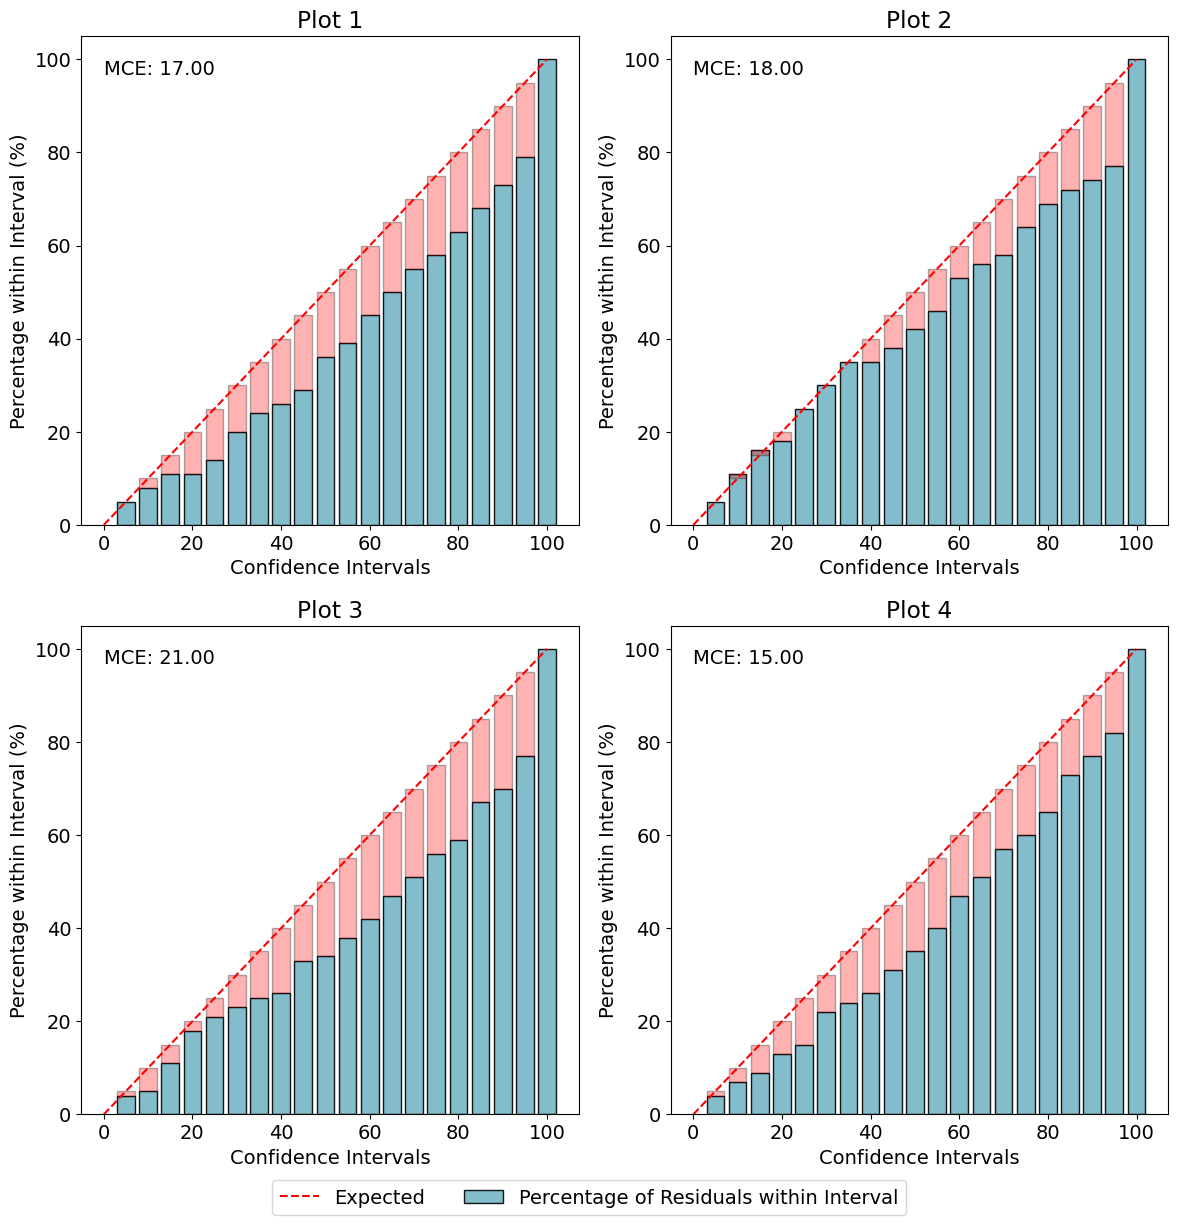

In [8]:

# Dummy data for demonstration
y_test_pred_list = [np.random.normal(loc=0, scale=1, size=(100,)),
                    np.random.normal(loc=0, scale=1, size=(100,)),
                    np.random.normal(loc=0, scale=1, size=(100,)),
                    np.random.normal(loc=0, scale=1, size=(100,))]
y_test_std_list = [np.random.uniform(0.5, 1.5, size=(100,)),
                   np.random.uniform(0.5, 1.5, size=(100,)),
                   np.random.uniform(0.5, 1.5, size=(100,)),
                   np.random.uniform(0.5, 1.5, size=(100,))]
y_test_list = [np.random.normal(loc=0, scale=1, size=(100,)),
               np.random.normal(loc=0, scale=1, size=(100,)),
               np.random.normal(loc=0, scale=1, size=(100,)),
               np.random.normal(loc=0, scale=1, size=(100,))]

# Example usage of the function
plot_confidence_interval_bar_grid(y_test_pred_list, y_test_std_list, y_test_list, bins=20) 

37877


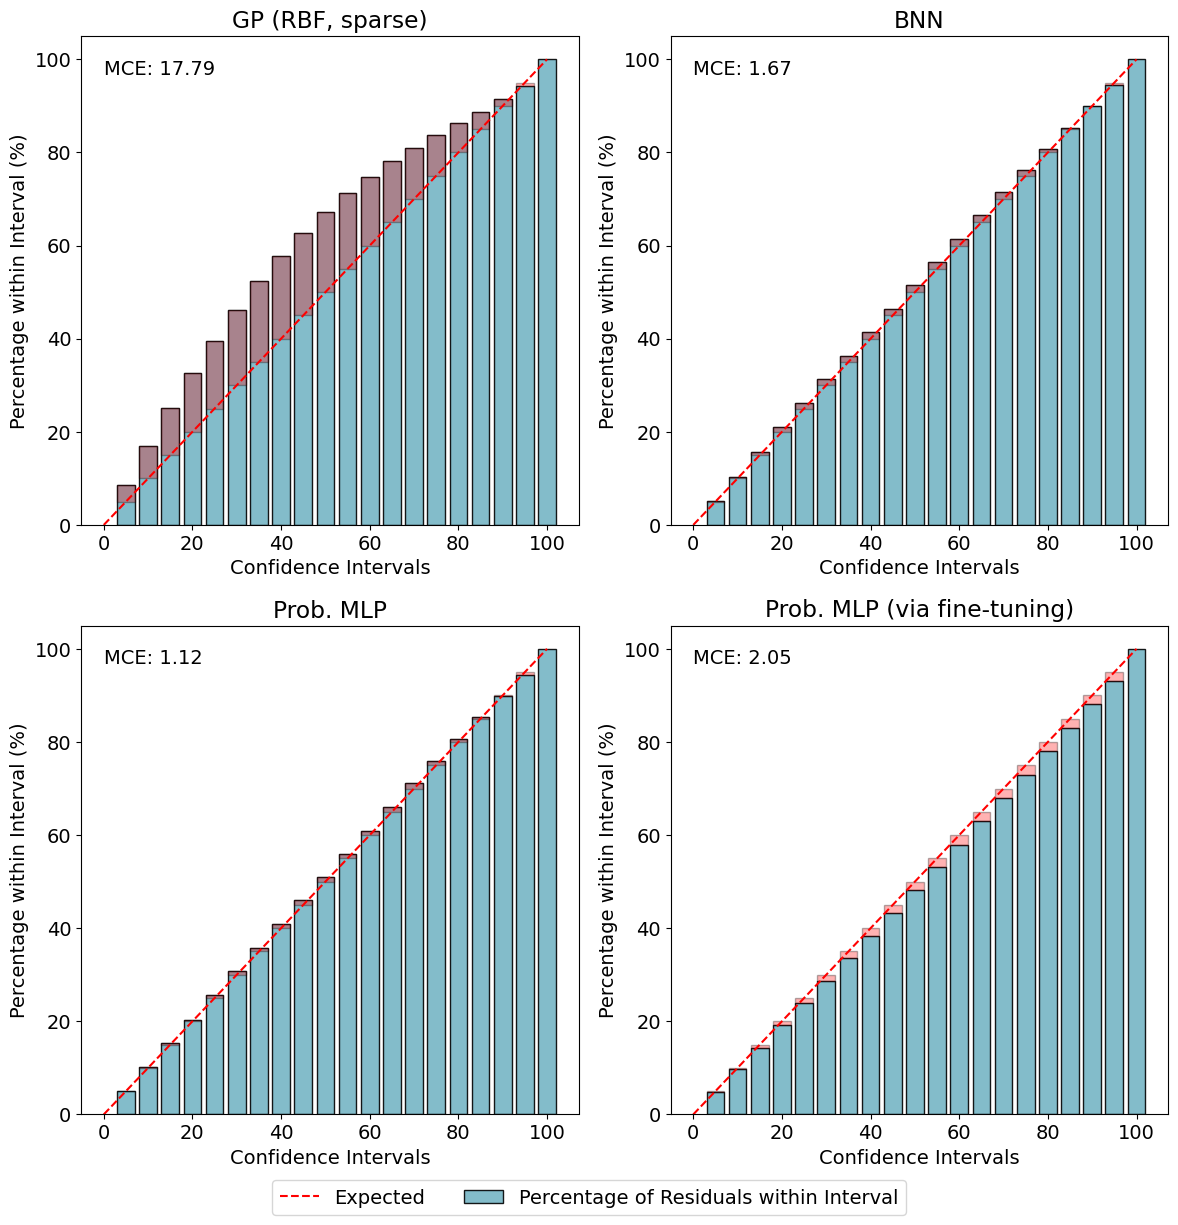

In [10]:
df_preds = pd.read_csv('preds.csv')

bnn_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_pred'].tolist())
bnn_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_stddevs'].tolist())
mlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Probabilistic MLP (Joint Sub-models)', 'y_test_pred'].tolist())
mlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Probabilistic MLP (Joint Sub-models)', 'y_test_stddevs'].tolist())
gp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_pred'].tolist())
gp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_stddevs'].tolist())
ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Fine-tuned', 'y_test_pred'].tolist())
ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Fine-tuned', 'y_test_stddevs'].tolist())

y_test_pred_list = [gp_pred,
                    bnn_pred,
                    mlp_pred,
                    ft_pred]

y_test_std_list = [gp_stddevs,
                    bnn_stddevs,
                    mlp_stddevs,
                    ft_stddevs]

y_test_list = [y_test,
                y_test,
                y_test,
                y_test]

print(len(y_test_list[0]))

titles = ["GP (RBF, sparse)",
            "BNN",
            "Prob. MLP",
            "Prob. MLP (via fine-tuning)"]

plot_confidence_interval_bar_grid(y_test_pred_list, y_test_std_list, y_test_list, bins=20, rmses=None, titles=titles) 

In [4]:
import pandas as pd

COLAB = False
DATA_PATH = "."

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df = pd.read_pickle(open(DATA_PATH + '/cleaned_data.pkl','rb'))

In [7]:
# Datetime column
DATETIME_COL = 'Date.time'

units = {
'Wind.speed.me': 'm/s',
'Wind.speed.sd': 'm/s', 
'Wind.speed.min': 'm/s',
'Wind.speed.max': 'm/s',
'Front.bearing.temp.me': '°C',
'Front.bearing.temp.sd': '°C',
'Front.bearing.temp.min': '°C',
'Front.bearing.temp.max': '°C',
'Rear.bearing.temp.me': '°C',
'Rear.bearing.temp.sd': '°C',
'Rear.bearing.temp.min': '°C',
'Rear.bearing.temp.max': '°C',
'Rotor.bearing.temp.me': '°C',
'Stator1.temp.me': '°C',
'Nacelle.ambient.temp.me': '°C',
'Nacelle.temp.me': '°C',
'Transformer.temp.me': '°C',
'Gear.oil.temp.me': '°C',
'Gear.oil.inlet.temp.me': '°C',
'Top.box.temp.me': '°C',
'Hub.temp.me': '°C',
'Conv.Amb.temp.me': '°C',
'Rotor.bearing.temp.me': '°C',
'Transformer.cell.temp.me': '°C',
'Motor.axis1.temp.me': '°C',
'Motor.axis2.temp.me': '°C',
'CPU.temp.me': '°C',
'Blade.ang.pitch.pos.A.me': '°',
'Blade.ang.pitch.pos.B.me': '°',
'Blade.ang.pitch.pos.C.me': '°',
'Gear.oil.inlet.press.me': 'bar',
'Gear.oil.pump.press.me': 'bar',
'Drive.train.acceleration.me': 'mm/s^2',
'Tower.Acceleration.x': 'mm/s^2',
'Tower.Acceleration.y': 'mm/s^2'
}

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.inlet.temp.me',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'

TURBINE_ID = 5
df = df[df['turbine'] == TURBINE_ID]
df = df.dropna(subset=features + [output_feature] + [DATETIME_COL])
df.reset_index(drop=True, inplace=True)
df_live = df[-144:]
df_live

,Date.time,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,...,Blade.ang.pitch.pos.C.sd,Blade.ang.pitch.pos.C.min,Blade.ang.pitch.pos.C.max,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year
189237,2021-06-15 08:10:00,-1.238843,0.350103,-1.89926,-0.832260,0.000000,1.303757,0.562964,0.207375,2.152875,...,0.000000,44.990002,44.990002,-0.965012,57.135079,3.585414,3.247329,3.683167,5,2021
189238,2021-06-15 08:20:00,-1.488746,0.423818,-2.19802,-0.906950,0.000000,1.454507,0.503980,0.382875,2.358750,...,0.000000,44.990002,44.990002,26.453362,158.469444,3.590915,3.992820,4.528044,5,2021
189239,2021-06-15 08:30:00,-0.970970,0.129675,-1.20571,-0.597520,0.000000,0.771825,0.416179,0.136501,1.705500,...,0.000000,44.990002,44.990002,-0.800030,48.727246,3.613845,4.392685,4.109208,5,2021
189240,2021-06-15 08:40:00,-1.225983,0.327326,-1.92060,-0.842930,0.000000,1.307587,0.481572,0.441750,2.156625,...,0.003570,44.990002,45.000000,-0.230106,51.762874,3.560794,4.662606,3.923348,5,2021
189241,2021-06-15 08:50:00,-1.682659,0.311778,-2.02730,-0.981640,0.000000,1.782206,0.665286,0.421875,2.738250,...,0.002179,44.990002,45.000000,39.667048,220.649119,3.603590,3.480225,4.062533,5,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189376,2021-06-16 07:40:00,227.855176,90.820520,69.04953,370.848175,205.801358,5.004308,1.035788,3.032062,6.605342,...,0.176165,0.000000,0.500000,84.802167,345.358664,4.768853,49.262235,19.572605,5,2021
189377,2021-06-16 07:50:00,113.824804,59.686158,11.36355,255.925110,122.639790,4.258016,0.794145,2.742857,5.638236,...,0.450279,0.000000,1.500000,76.972613,323.475458,4.939798,37.280809,23.563742,5,2021
189378,2021-06-16 08:00:00,93.655473,41.102618,27.02812,160.454422,138.363597,4.399672,0.703871,3.176478,6.496566,...,0.353304,0.000000,0.990000,76.042935,321.432741,4.721654,54.585392,19.899586,5,2021
189379,2021-06-16 08:10:00,44.301383,29.984073,-9.96578,137.341568,59.726457,3.536844,0.693937,1.941700,5.211299,...,0.419311,0.000000,1.500000,75.300223,319.656665,4.554223,55.858536,17.180753,5,2021


In [12]:
X_live, y_live = df_live[features].to_numpy(), df_live[output_feature].to_numpy()

In [17]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import tensorflow_probability as tfp

from utils import *

def generic_model(X_train_full):
    inputs = Input(shape=(X_train_full.shape[1],))
    hidden1 = Dense(300, activation="relu")(inputs)
    hidden2 = Dense(200, activation="relu")(hidden1)
    hidden3 = Dense(100, activation="relu")(hidden2)

    params = Dense(2)(hidden3)

    dist = tfp.layers.DistributionLambda(normal_softplus)(params)

    model = Model(inputs=inputs, outputs=dist)
    model.compile(Adam(learning_rate=0.001), loss=NLL)

    return model

# Train the initial model using X_full with the checkpoint callback
generic_model = generic_model(X_live)
generic_model.summary()

checkpoint_path = 'saved_models/finetuned.keras'

def create_model_finetune(X_train, generic_model, seed):
    keras.utils.set_random_seed(seed)

    inputs = Input(shape=(X_train.shape[1],))

    # Step 1: Load the architecture and weights of the previously trained model
    pretrained_model_layers = generic_model.layers[1:]
    l = inputs

    for layer in pretrained_model_layers:
        layer.trainable = True
        l = layer(l)

    model_mlp_gaussian = Model(inputs=inputs, outputs=l)
    model_mlp_gaussian.compile(Adam(learning_rate=1e-4), loss=NLL)

    return model_mlp_gaussian

model_finetune = create_model_finetune(X_live, generic_model, 42)
model_finetune.summary()

generic_model.load_weights(checkpoint_path)
evaluation = model_finetune.evaluate(X_live, y_live)
print("Evaluation Loss:", evaluation)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_12 (Dense)            (None, 300)               10500     
                                                                 
 dense_13 (Dense)            (None, 200)               60200     
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dense_15 (Dense)            (None, 2)                 202       
                                                                 
 distribution_lambda_1 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                         
                                                           

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'saved_models/finetuned.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)